# Multi-label classification of music into emotions

 

1. Utilizando a base disponível em: https://www.kaggle.com/srinivas365/multilabel-classification-emotions elabore uma solução utilizando dois algoritmos de aprendizagem de máquina do seu conhecimento para classificar a emoção da música (escolha como você representará a saída, uma vez que algumas músicas podem pertencer a duas categorias). Justifique a escolha dos dois algoritmos de aprendizagem de maquina utilizados e discuta os resultados obtidos em ambos. Divida (aleatoriamente) o conjunto em treinamento e teste: 80% e 20%. Os resultados dessa questão deverão ser descritos detalhadamente no relatório através de três pontos principais:

- Análise da base de dados: identificar instancias com atributos incompletos, gerar matriz de correlação, identificar a presença de outliers e verificar se as classes estão balanceadas. O balanceamento devera ser ilustrado por meio de gráficos (e.g. histograma);

- Análise dos resultados considerando matriz de confusão, especificidade, sensibilidade, medida f1 e acurácia. Descreva detalhadamente os resultados obtidos por cada métrica,justificando a diferença entre eles.

**Bônus**: Altere dois parâmetros de cada algoritmo de aprendizagem de maquina utilizados na questão e discuta os resultados obtidos. Exemplo: alterar a quantidade de k vizinhos e a função de distancia utilizada, alterar a função kernel do SVM, alterar a arquitetura da rede neural (e.x. camadas e função de ativação, alterar o otimizador e a taxa de aprendizado).

## Adicionando Bibliotecas e  Pacotes

In [1]:
%load_ext tensorboard
# Data Preprocessing Packages
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import re
from scipy.io.arff import loadarff

# Data Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns

# ML Packages
from sklearn import model_selection, svm
from sklearn.svm import SVR
from sklearn.metrics import auc, accuracy_score, confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV, StratifiedKFold, KFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
import xgboost as xgb
import time
from tensorflow.keras.callbacks import TensorBoard
from keras import backend as K
import keras
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPool1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D
from imblearn.over_sampling import RandomOverSampler
from sklearn.naive_bayes import GaussianNB
from skmultilearn.ensemble import RakelD
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.utils import class_weight
from skmultilearn.model_selection import iterative_train_test_split
from sklearn.metrics import multilabel_confusion_matrix,ConfusionMatrixDisplay, f1_score
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from sklearn import metrics

Using TensorFlow backend.


## Adquirindo o Dataset

In [2]:
df = pd.read_csv('multilabel-classification-emotions/emotions.csv', encoding = 'utf-8')
df.drop(columns = ['Unnamed: 0'],inplace = True)
df.head()

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,...,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,...,2.0,0.245457,0.105065,0.405399,0.0,1.0,1.0,0.0,0.0,0.0
1,0.081374,0.272747,0.085733,-62.584437,3.183163,-0.218145,0.163038,0.620251,0.458514,0.041426,...,2.0,0.343547,0.276366,0.710924,1.0,0.0,0.0,0.0,0.0,1.0
2,0.110545,0.273567,0.084410,-65.235325,2.794964,0.639047,1.281297,0.757896,0.489412,0.627636,...,3.0,0.188693,0.045941,0.457372,0.0,1.0,0.0,0.0,0.0,1.0
3,0.042481,0.199281,0.093447,-80.305152,5.824409,0.648848,1.754870,1.495532,0.739909,0.809644,...,2.0,0.102839,0.241934,0.351009,0.0,0.0,1.0,0.0,0.0,0.0
4,0.074550,0.140880,0.079789,-93.697749,5.543229,1.064262,0.899152,0.890336,0.702328,0.490685,...,2.0,0.195196,0.310801,0.683817,0.0,0.0,0.0,1.0,0.0,0.0


In [3]:
df.info() #Adquirindo informações básicas de cada coluna

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 593 entries, 0 to 592
Data columns (total 78 columns):
Mean_Acc1298_Mean_Mem40_Centroid    593 non-null float64
Mean_Acc1298_Mean_Mem40_Rolloff     593 non-null float64
Mean_Acc1298_Mean_Mem40_Flux        593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_0      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_1      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_2      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_3      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_4      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_5      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_6      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_7      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_8      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_9      593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_10     593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_11     593 non-null float64
Mean_Acc1298_Mean_Mem40_MFCC_12     593 

In [4]:
df.describe()

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,...,BH_HighLowRatio,BHSUM1,BHSUM2,BHSUM3,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
count,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,...,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000,593.000000
mean,0.069309,0.195399,0.085695,-72.998228,4.979178,0.602395,1.694625,0.634156,0.833964,0.508060,...,2.099494,0.412940,0.354901,0.959906,0.291737,0.279933,0.445194,0.249578,0.283305,0.318718
std,0.031293,0.117605,0.009260,7.580804,2.071792,1.017603,0.606581,0.448746,0.368312,0.303277,...,0.316040,0.339559,0.362262,0.651827,0.454946,0.449345,0.497407,0.433134,0.450984,0.466373
min,0.010201,0.038286,0.070932,-99.090802,0.051474,-2.277307,-0.604609,-1.143864,-0.237114,-0.444623,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.044781,0.107742,0.079018,-77.078349,3.409922,-0.113441,1.307242,0.373195,0.605057,0.309033,...,2.000000,0.179411,0.099424,0.513974,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.065251,0.169757,0.083637,-72.474302,4.642338,0.588380,1.731031,0.618838,0.819652,0.534665,...,2.000000,0.309902,0.246193,0.804229,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.086290,0.257668,0.091323,-68.292848,6.439446,1.293202,2.072488,0.925091,1.051206,0.708430,...,2.000000,0.529859,0.472593,1.242089,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000
max,0.195412,0.698277,0.159460,-56.297652,12.069754,3.910873,4.382370,2.252710,2.358098,1.484489,...,3.000000,1.795128,1.797765,3.422899,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## EDA:

### Sobre os dados:
Esse dataset contém 593 diferentes músicas, foram extraídos os primeiros 30 segundos após 30 segundos de música.

1. Atributos de ritmo: Foram extraídos a partir de um histograma de batidas. Foram selecionados os dois maiores picos, suas respectivas amplitudes, seus BPMs(Batidas Por Minuto) e em adição foi feita a soma entre diferentes intervalos do histograma de batidas. Levando a um total de oito atributos de ritmo.
<br/>
<br/>
2. Atributos de timbre: O sinal foi dividido em frames e para cada frame foi calculada uma amplitude de espectro para então encontrar os atributos de MFCC, que são muito utilizados para adquirir informações em sinais analógicos. Foram utilizados os primeiros 13 MFCCs, porém ao realizar uma Transformada de Fourier de curto termo(FFT) foram encontrados mais três atributos, resultando em 13 MFCCs e 3 FFT. Então foi calculada a média, o desvio padrão, o desvio padrão médio e o desvio padrão do desvio padrão. Levando a um total de 64 atributos de timbre.
<br/>
<br/>
3. Classes de Emoção: Esses são os alvos da classificação, são 6 classes projetadas de forma que uma música possa representar mais de uma emoção. Assim tornando o problema em um de Multi-Label.

Disponível em: https://www.kaggle.com/srinivas365/multilabel-classification-emotions

As primeiras observações a serem feitas com essas informações são :

1. Não existem dados ausentes, mas isso não anula o fato de que podem existir informações inconsistentes.
2. Existem **muitos** atributos nesse dataset, muito provavelmente alguns desses estão correlacionados.
3. Esse é um problema de classificação de multilabel, terá que ser analisada a distribuição das classes de maneira detalhada para evitar o desbalanceamento.

### Análise da distribuição das classes:
1. Irei dividir o dataset em Classes e Atributos, para analisar as Classes separadamente
2. Então irei analisar a distribuição das classes.
3. Depois será feita uma análise detalhada de cada combinação no dataset

In [5]:
labels = ['amazed-suprised', 'happy-pleased', 'relaxing-calm', 'quiet-still', 'sad-lonely', 'angry-aggresive']

feats_df = df.drop(columns = labels)
labels_df = df[labels]

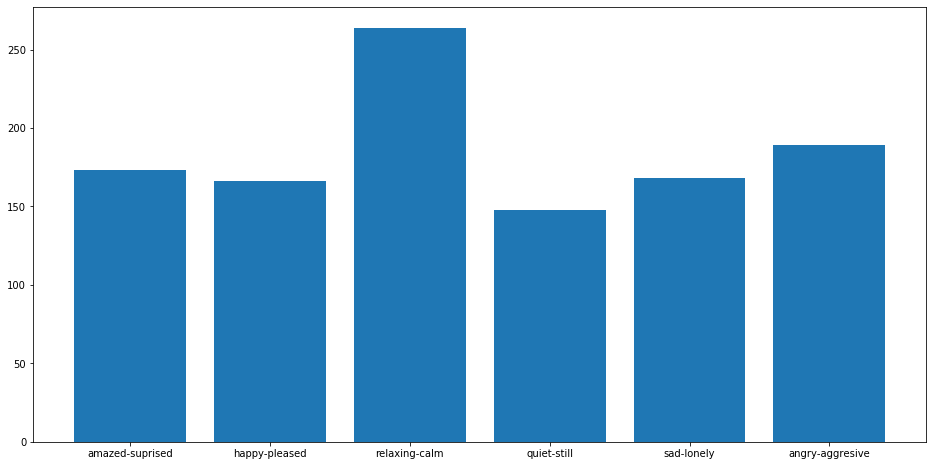

In [6]:
label_d = {'amazed-suprised' : 0, 'happy-pleased': 0, 'relaxing-calm' : 0, 'quiet-still' : 0, 'sad-lonely': 0, 'angry-aggresive' : 0}
for col in labels_df.columns:
    label_d[col] += len(labels_df[labels_df[col] == 1])

plt.figure(figsize = (16,8))
plt.bar(range(len(label_d)), list(label_d.values()), align='center')
plt.xticks(range(len(label_d)), list(label_d.keys()))
plt.show()

A partir desse gráfico é possível observar um desbalanceamento entre as classes. Enquanto existem muitas músicas que transmitem 'relaxing-calm', poucas representam 'quiet-still'. 

In [7]:
def transform_multiclass(orig_df):
    df = orig_df.copy()
    classe = []
    for i in range(len(df)):
        classe.append('')
    
    for i in range(len(df)):
        if df['amazed-suprised'][i] == 1:
            classe[i] = classe[i] + 'surprised-'
        if df['happy-pleased'][i] == 1:
            classe[i] = classe[i] + 'happy-'
        if df['relaxing-calm'][i] == 1:
            classe[i] = classe[i] + 'relaxing-'
        if df['quiet-still'][i] == 1:
            classe[i] = classe[i] + 'still-'
        if df['sad-lonely'][i] == 1:
            classe[i] = classe[i] + 'lonely-'
        if df['angry-aggresive'][i] == 1:
            classe[i] = classe[i] + 'angry-'
            
    df['Class'] = classe
    df.drop(['angry-aggresive','amazed-suprised','happy-pleased','relaxing-calm','quiet-still','sad-lonely'],axis=1,inplace = True)
    return df

In [8]:
class_label_df = transform_multiclass(labels_df)
class_label_df['Class'].unique()

array(['happy-relaxing-', 'surprised-angry-', 'happy-angry-', 'relaxing-',
       'still-', 'surprised-happy-', 'angry-', 'relaxing-still-lonely-',
       'surprised-', 'relaxing-lonely-', 'lonely-', 'lonely-angry-',
       'happy-', 'relaxing-angry-', 'surprised-happy-angry-',
       'relaxing-still-', 'surprised-lonely-', 'relaxing-lonely-angry-',
       'happy-lonely-', 'surprised-happy-relaxing-',
       'surprised-relaxing-', 'happy-relaxing-still-', 'still-lonely-',
       'happy-still-', 'relaxing-still-angry-', 'still-lonely-angry-',
       'surprised-lonely-angry-'], dtype=object)

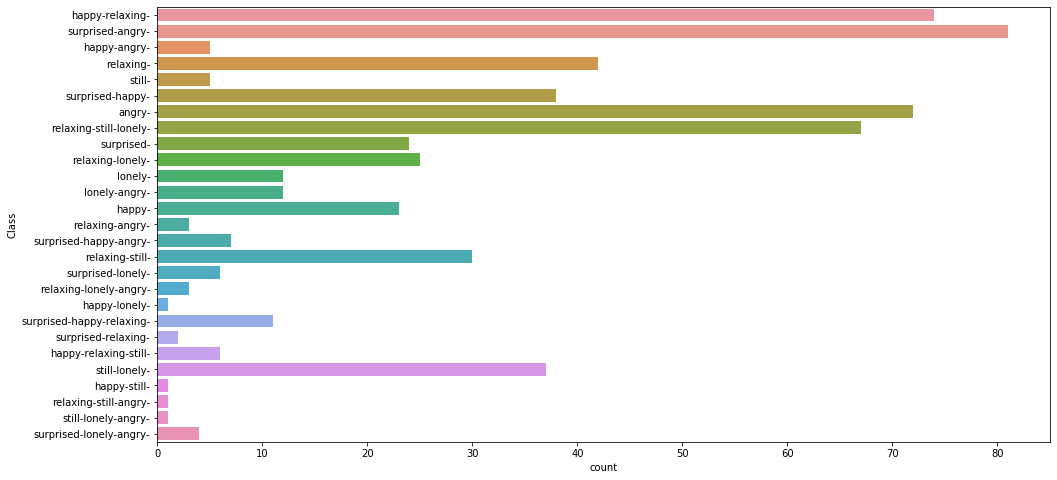

surprised-angry-             81
happy-relaxing-              74
angry-                       72
relaxing-still-lonely-       67
relaxing-                    42
surprised-happy-             38
still-lonely-                37
relaxing-still-              30
relaxing-lonely-             25
surprised-                   24
happy-                       23
lonely-                      12
lonely-angry-                12
surprised-happy-relaxing-    11
surprised-happy-angry-        7
happy-relaxing-still-         6
surprised-lonely-             6
happy-angry-                  5
still-                        5
surprised-lonely-angry-       4
relaxing-lonely-angry-        3
relaxing-angry-               3
surprised-relaxing-           2
still-lonely-angry-           1
happy-lonely-                 1
relaxing-still-angry-         1
happy-still-                  1
Name: Class, dtype: int64

In [9]:
plt.figure(figsize = (16,8))
sns.countplot(y = class_label_df.Class)
plt.show()
class_label_df.Class.value_counts()

Analisando detalhadamente cada combinação de classes presente no dataset, é possível perceber que há um forte desbalanceamento, para resolver isso irei remover as classes que possuem apenas uma música e então farei um RandomOverSample.

### Correlação dos Dados

In [10]:
df.corr().style.background_gradient(cmap='coolwarm')

Com a matriz de correlação acima é possível observar que muitos atributos estão com taxa de correlação maior que 0.8, então irei remover essas colunas a fim de reduzir a dimensionalidade e a redundância de informações no dataset.

### Verificação de dados duplicados e nulos

In [11]:
df.duplicated().unique()

array([False])

Não existe nenhum dado duplicado no dataset

In [12]:
df.isnull().sum().unique()

array([0])

Não existem nenhum dado nulo

## Limpeza de Dados:

### Removendo atributos muito correlacionados:

In [13]:
# Matriz correlacional
corr_matrix = feats_df.corr().abs()

# Seleciona parte de cima da matriz
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Acha coluna com index com correlação maior que 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

#Remove colunas com alta correlação
df.drop(df[to_drop], axis=1,inplace = True)

### Balanceamento dos dados:
Como as classes estão desbalanceadas, utilizarei a técnica de oversampling RandomOverSampler. Irei realizar testes sem utilizar o oversampler também e irei selecionar o método que obtenha melhor resultado.

Adicionando label com a classe de cada música

In [14]:
df['Class'] = class_label_df['Class']
df.head()

,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,...,BH_LowPeakBPM,BH_HighPeakBPM,BH_HighLowRatio,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive,Class
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,...,68.0,136.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,happy-relaxing-
1,0.081374,0.272747,0.085733,-62.584437,3.183163,-0.218145,0.163038,0.620251,0.458514,0.041426,...,70.0,140.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,surprised-angry-
2,0.110545,0.273567,0.084410,-65.235325,2.794964,0.639047,1.281297,0.757896,0.489412,0.627636,...,61.0,183.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,happy-angry-
3,0.042481,0.199281,0.093447,-80.305152,5.824409,0.648848,1.754870,1.495532,0.739909,0.809644,...,66.0,132.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,relaxing-
4,0.074550,0.140880,0.079789,-93.697749,5.543229,1.064262,0.899152,0.890336,0.702328,0.490685,...,100.0,200.0,2.0,0.0,0.0,0.0,1.0,0.0,0.0,still-


Criando novo dataset sem os antigos labels

In [15]:
class_df = df.drop(labels,1)
print(class_df.shape)
class_df.head()

(593, 54)


,Mean_Acc1298_Mean_Mem40_Centroid,Mean_Acc1298_Mean_Mem40_Rolloff,Mean_Acc1298_Mean_Mem40_Flux,Mean_Acc1298_Mean_Mem40_MFCC_0,Mean_Acc1298_Mean_Mem40_MFCC_1,Mean_Acc1298_Mean_Mem40_MFCC_2,Mean_Acc1298_Mean_Mem40_MFCC_3,Mean_Acc1298_Mean_Mem40_MFCC_4,Mean_Acc1298_Mean_Mem40_MFCC_5,Mean_Acc1298_Mean_Mem40_MFCC_6,...,Std_Acc1298_Std_Mem40_MFCC_6,Std_Acc1298_Std_Mem40_MFCC_7,Std_Acc1298_Std_Mem40_MFCC_8,Std_Acc1298_Std_Mem40_MFCC_9,Std_Acc1298_Std_Mem40_MFCC_10,BH_LowPeakAmp,BH_LowPeakBPM,BH_HighPeakBPM,BH_HighLowRatio,Class
0,0.034741,0.089665,0.091225,-73.302422,6.215179,0.615074,2.037160,0.804065,1.301409,0.558576,...,0.168246,0.115849,0.136020,0.110514,0.100517,0.051035,68.0,136.0,2.0,happy-relaxing-
1,0.081374,0.272747,0.085733,-62.584437,3.183163,-0.218145,0.163038,0.620251,0.458514,0.041426,...,0.057991,0.059393,0.059457,0.053439,0.067684,0.295031,70.0,140.0,2.0,surprised-angry-
2,0.110545,0.273567,0.084410,-65.235325,2.794964,0.639047,1.281297,0.757896,0.489412,0.627636,...,0.139323,0.109279,0.090650,0.117886,0.100852,0.161574,61.0,183.0,3.0,happy-angry-
3,0.042481,0.199281,0.093447,-80.305152,5.824409,0.648848,1.754870,1.495532,0.739909,0.809644,...,0.124399,0.155513,0.167114,0.113774,0.112815,0.043012,66.0,132.0,2.0,relaxing-
4,0.074550,0.140880,0.079789,-93.697749,5.543229,1.064262,0.899152,0.890336,0.702328,0.490685,...,0.142092,0.222804,0.329188,0.251668,0.265049,0.029308,100.0,200.0,2.0,still-


Removendo outliers

In [16]:
classes = class_label_df.Class.value_counts().index
class_series =class_label_df['Class'].value_counts()
outliers = []
for label in classes:
    if class_series[label] < 5:
        outliers.append(label)
outliers

['surprised-lonely-angry-',
 'relaxing-lonely-angry-',
 'relaxing-angry-',
 'surprised-relaxing-',
 'still-lonely-angry-',
 'happy-lonely-',
 'relaxing-still-angry-',
 'happy-still-']

In [17]:
for outlier in outliers:
    class_df = class_df[class_df['Class'] != outlier]

print(class_df.shape)

(577, 54)


In [18]:
X = class_df.drop('Class',1)
y = class_df['Class']

print(X.shape, y.shape)

(577, 53) (577,)


### Separação entre treino e teste

#### Utilizando o OverSampler

In [19]:
ros = RandomOverSampler()
X_over, y_over = ros.fit_resample(X, y)
print(X_over.shape)
print(y_over.shape)

(1539, 53)
(1539,)


In [20]:
y_over.value_counts()

happy-relaxing-              81
happy-angry-                 81
angry-                       81
surprised-                   81
surprised-angry-             81
relaxing-lonely-             81
still-lonely-                81
surprised-lonely-            81
relaxing-still-              81
surprised-happy-relaxing-    81
surprised-happy-             81
still-                       81
happy-relaxing-still-        81
lonely-                      81
surprised-happy-angry-       81
lonely-angry-                81
happy-                       81
relaxing-                    81
relaxing-still-lonely-       81
Name: Class, dtype: int64

### Train and Test Split

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X_over,y_over,test_size = 0.2, random_state = 42)

train_df = X_train.join(y_train)
test_df = X_test.join(y_test)

In [22]:
test_df.shape

(308, 54)

In [23]:
test_df.duplicated().sum()

99

In [24]:
test_df.drop_duplicates(inplace = True)
test_df.shape

(209, 54)

In [25]:
train_df.shape

(1231, 54)

In [26]:
le = LabelEncoder()

X_train = train_df.drop('Class',1).values
X_train = preprocessing.scale(X_train)
y_train = le.fit_transform(train_df['Class'])

X_test = test_df.drop('Class',1).values
X_test = preprocessing.scale(X_test)
y_test = le.fit_transform(test_df['Class'])

X_train

array([[ 0.03675074,  0.70548778,  0.88137231, ...,  1.5499583 ,
         1.20370553, -0.31835524],
       [-1.35982546,  3.34378922,  0.9291352 , ..., -0.06641897,
        -0.30765342, -0.31835524],
       [ 3.35111026,  1.71954713, -0.30733888, ..., -0.87460761,
        -1.0633329 , -0.31835524],
       ...,
       [-1.07599655, -1.2451731 , -0.8465722 , ..., -1.00930571,
         0.63694592,  2.44147084],
       [ 0.08576379, -0.57375718, -0.39818586, ..., -0.40316423,
        -0.62251987, -0.31835524],
       [ 0.1357952 , -0.49288511, -0.50111977, ...,  1.81935452,
         1.45559869, -0.31835524]])

### Treino e Teste:

O conjunto de dados foi dividido entre 80% para treino e 20% para teste, utilizando um determinado número para o random_state. O random_state garante que se modelo atingir um bom resultado será possível atingir a mesma divisão em previsões futuras.
<br/>
<br/>
<br/>
**Métricas de Avaliação**:
1. Hamming Loss: Corresponde à distância de hamming entre as classes reais e as classes previstas pelo modelo.
2. F1 Score: Média ponderada entre a precisão e a sensibilidade. Tem melhor valor em 1.0 e pior em 0.0
3. Confusion Matrix: Ilustra o número de predições corretas e incorretas em cada classe.
4. Sensibilidade: Medida de completude do modelo.
5. Especificidade: Capacidade do modelo em predizer corretamente a ausência da condição para casos que realmente não a têm.

### Random Forest:



In [80]:
classifier = RandomForestClassifier(n_estimators = 100,n_jobs = -1, verbose = 0, random_state = 30)
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
f1 = round(f1_score(y_test,y_pred, average = 'micro'),2)
accuracy = round(accuracy_score(y_test,y_pred),2)

print(f'Accuracy: {accuracy*100}%\n')
print(f'F1 Score: {f1*100}%\n')
print(f'Confusion Matrix:\n{cm}')

Accuracy: 85.0%

F1 Score: 85.0%

Confusion Matrix:
[[10  0  0  1  0  0  0  2  0  0  0  0  0  1  4  0  0  0  0]
 [ 0 13  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  9  0  0  0  1  0  0  2  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  6  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0 10  1  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 15  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  1 13  0  1  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0 13  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0  0  0  0  2  6  0  1  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  

### XGBoost

In [64]:
#xgb_params = {
#    'objective': 'multi:softmax'
#}

classifier = OneVsRestClassifier(xgb.XGBClassifier(n_jobs = -1))
classifier.fit(X_train, y_train)

y_pred = classifier.predict(X_test)

cm = metrics.confusion_matrix(y_test, y_pred)
f1 = round(f1_score(y_test,y_pred, average = 'micro'),3)
accuracy = round(accuracy_score(y_test,y_pred),3)

print(f'Accuracy: {accuracy*100}%\n')
print(f'F1 Score: {f1*100}%\n')
print(f'Confusion Matrix:\n{cm}')

Accuracy: 80.4%

F1 Score: 80.4%

Confusion Matrix:
[[ 8  0  0  2  0  1  0  1  0  0  0  0  0  2  4  0  0  0  0]
 [ 0 13  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  7  0  1  0  2  0  0  1  0  0  0  0  3  0  0  0]
 [ 0  0  0  0  5  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  3  0  0  0 10  0  1  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0 14  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 13  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  1  0  1 12  0  1  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  5  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  2  0  0 11  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0]
 [ 4  0  0  0  0  0  0  0  0  0  0  0  0  0  7  1  1  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0  0  0  0  0  

### **Redes Neurais Convolucionais:**

Para a Rede Neural irei fazer uma análise com os resultados para o conjunto de dados com o Oversampling e sem o Oversampling. A arquitetura da Rede Neural foi baseada em uma SmallerVGGNet. Utilizarei o TensorBoard para definir qual o melhor número de camadas Convolucionais, Densas e tamanho de cada camada.

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
dense_layers = [1,2,3,4]
conv_layers = [0,1,2,3]
layer_sizes = [32,64,128,256]

X_train_n = X_train
y_train_n = y_train
X_test_n = X_test
y_test_n = y_test


X_train_n = preprocessing.scale(X_train_n)
X_test_n = preprocessing.scale(X_test_n)

X_train_n = np.reshape(X_train_n, (X_train_n.shape[0], X_train_n.shape[1] , 1))
X_test_n = np.reshape(X_test_n, (X_test_n.shape[0], X_test_n.shape[1], 1))
sw = class_weight.compute_sample_weight('balanced', y_train_n)

for dense_layer in dense_layers:
    for layer_size in layer_sizes:
        for conv_layer in conv_layers:
            NAME = f'emotions_cnn-dense-{dense_layer}-layer{layer_size}-conv{conv_layer}-time-{int(time.time())}'
            tb_callback = TensorBoard(log_dir = f'logs/{NAME}')
            
            model2 = Sequential()
            
            if conv_layer > 0:
                model2.add(Conv1D(layer_size, 3,padding='valid', input_shape=(53,1),activation='tanh'))
                model2.add(BatchNormalization())
                model2.add(MaxPooling1D(pool_size=(4)))
                model2.add(Dropout(0.2)) 
                
                for l in range(conv_layer - 1):
                    model2.add(Conv1D(layer_size, 3,padding='valid',activation='tanh'))
                    model2.add(BatchNormalization())
                    model2.add(MaxPooling1D(pool_size=(2)))
                    model2.add(Dropout(0.2)) 
            
                                   
            else:
                model2.add(Flatten())
                model2.add(Dense(layer_size, input_shape = (53,) ,activation='tanh'))
            
            model2.add(Dropout(0.2))  
            model2.add(Flatten())
            for l in range(dense_layer):
                model2.add(Dense(layer_size, activation='relu'))
                model2.add(BatchNormalization())
                model2.add(Dropout(0.1))
                
            model2.add(Dropout(0.3))
            model2.add(Dense(20, activation="softmax"))

            model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

            history = model2.fit(X_train_n, y_train_n, 
                                 batch_size=BATCH_SIZE, 
                                 epochs=EPOCHS,
                                 verbose= 0,
                                 validation_data=(X_test_n, y_test_n),
                                 callbacks = [tb_callback])
            
score = model2.evaluate(X_test_n, y_test_n, verbose=1)

print(f'Loss: {score[0]}\nAccuracy: { round(score[1], 2)*100}%')
y_pred = np.argmax(model2.predict(X_test_n), axis = 1)


cm = metrics.confusion_matrix(y_test_n, y_pred)
f1_score1 = round(f1_score(y_test_n,y_pred,average='micro'),3)

print(f'F1 Score: {f1_score1*100}%\n')
print(f'Confusion Matrix:\n{cm}')
    
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model train vs validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

### Resultados e trabalhos futuros:

Apesar de não ter atingido uma acurácia muito alta é possível afirmar que o resultado foi satisfatório diante de trabalhos anteriores relacionados a esse conjunto de dados. O método com melhores resultados utilizou o algoritmo Random Forest com o suporte do método de transformação RakelD de uma biblioteca específica para problemas de multilabel. O resultado de f1 foi de 0.7, enquanto a taxa de erro de hamming foi de 0.18.
<br/>
<br/>
Foi possível notar também que para CNNs o dataset sem OverSample possui melhores resultados.
<br/>
<br/>
Para trabalhos futuros planeja-se transformar completamente o problema em um de multiclasse, visto que o algoritmo de Random Forest teve um resultado bom nesse formato. Além disso, espera-se resolver utilizando a Lógica Fuzzy, visto que esse problema se encaixa como um problema para esse tipo de algoritmo.
<br/>
<br/>
No entanto a experiência que o conjunto de dados fornece não é diversa e o modelo não terá bons resultados sem diversidade nos dados. Se o objetivo é criar um detector de emoções em músicas é desejável que mais dados sejam coletados e que mais pessoas atuem nesse processo. Visto que na criação desse dataset apenas três pessoas participaram e para uma tarefa tão subjetiva é necessário incluir gostos e sensações de muitas pessoas.